# Machine Learning with Text

We now turn our attention to a special case of machine learning, namely how to do ML when your data is a collection of text. This falls under the perview of _natural language processing_ (NLP). NLP is a vast subfield of computer science that deals with how to program computers to process and analyze large amounts of "natural" language data. This includes both speech and text, though we'll only focus on text here. Specifically, we'll learn just enough NLP to do ML on text datasets, and no more than that for now.

Since this is a security group we'll build a spam classifier from scratch. The dataset we'll use is the [SMS spam dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset), which we download off Kaggle using the shell command below. Kaggle is a great resource for datasets, and comes with its own specific version of `wget`, called `kaggle`, to handle downloading and managing its own datasets. The SMS dataset contains several thousand SMS messages collected in the UK a few years ago, some of which are labeled as spam and some of which are labeled as non-spam.

The goal of this notebook is to build a classifier to classify spam vs nonspam in this dataset of SMS messages. We start as always by loading the packages we'll need. Since NLP is a rich field with lots of intricacies, there are several Python packages designed for doing NLP. Among the most popular right now are NLTK, Spacy, and Gensim. 

We'll be working with NLTK and Spacy here to help with text processing. Since the dataset is unbalanced we'll also make use of the Imbalanced-Learn library, and of course Scikit-Learn to do the ML. We also use a special package for generating word clouds. After this we define several functions that will be used to load in the text, process the text, and visualize the text. We'll address what these do in a lot more below.

In [ ]:
#!kaggle datasets download -d uciml/sms-spam-collection-dataset

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

from scipy import sparse
import shap
from pathlib import Path

from wordcloud import WordCloud
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import re
import string
import spacy

np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

In [193]:
def get_text(text_file):
    df = pd.read_csv(text_file, encoding='ISO-8859-1')
    df = df[['v1','v2']]
    df.columns = ['labels','text']
    df.labels = df.labels.replace('ham',0)
    df.labels = df.labels.replace('spam',1)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

def process_text(text):
    # convert text to lowercase
    text = text.lower()
    # sub common symbols and remove non-ascii chars
    text = text.replace('&',' and ')
    text = text.replace('£','$ ')
    text = re.sub(r'[ ]{2,}',' ',text)
    text = re.sub(r'[.]{2,}',' ',text)
    text = text.encode("ascii", errors="ignore").decode()
    # remove all punctuation except apostrophes and dollar sign
    text = re.sub(r"[^\w\s'\$]",'',text)
    #text = text.translate(str.maketrans('', '', string.punctuation))
    # remove stop words
    text = ' '.join(word for word in text.split() if word not in stopwords.words('english'))
    # stem words
    stemmer = SnowballStemmer("english")
    stemmed_text = ''
    for word in text.split():
            stemmed_text += (stemmer.stem(word))+' '
    text = stemmed_text
    return text

def tokenize(text,nlp):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    tokens = ' '.join(token.text for token in doc)
    return tokens

def show_wordcloud(text):
    text = ' '.join([t for t in text])
    wordcloud = WordCloud().generate(text)
    plt.figure(figsize=(8,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    
def show_examples(df):
    sms = df[df.labels==0].iloc[0]
    print('label:',sms.labels)
    print(sms.text)

    print()

    sms = df[df.labels==0].iloc[1]
    print('label:',sms.labels)
    print(sms.text)

    print()

    sms = df[df.labels==1].iloc[0]
    print('label:',sms.labels)
    print(sms.text)

    print()

    sms = df[df.labels==1].iloc[1]
    print('label:',sms.labels)
    print(sms.text)
    
def get_scores(y,yhat):
    print('accuracy: ', round(accuracy_score(y,yhat),4))
    print('precision: ', round(precision_score(y,yhat),4))
    print('recall: ', round(recall_score(y,yhat),4))
    print('f1: ', round(f1_score(y,yhat),4))
    print('auc: ', round(roc_auc_score(y,yhat),4))
    print('confusion matrix:\n', confusion_matrix(y,yhat))
    
def plot_feature_importances(model,vectorizer,max_num=10):
    str_to_int = vectorizer.vocabulary_
    int_to_str = {val:key for key,val in str_to_int.items()}
    top_importances = -np.sort(-model.feature_importances_)[:max_num]
    top_features = np.argsort(-model.feature_importances_)[:max_num]
    top_words = [int_to_str[i] for i in top_features]
    
    plt.figure()
    plt.title('Feature importances')
    plt.barh(range(max_num), top_importances,
             color='r', align='center')
    plt.yticks(range(max_num), top_words)
    plt.ylim([-1, max_num])
    plt.show()

We start of course by loading in the text. A dataset of text are usually called a _corpus_ in NLP, and each separate string of text is called a _document_. We use the ever-useful Pandas library to load the spam dataset into a dataframe. The first column are the labels, with "1" being "spam" and "0" being "nonspam". The second column contains the corresponding documents. For example, the document in row 1 is classified as "0", i.e. nonspam. Etc.

In [140]:
text_path = '~/.kaggle/datasets/uciml/sms-spam-collection-dataset/'
text_name = 'spam.csv'
text_file = Path(text_path+text_name)
df = get_text(text_file)
df.head(10)

,labels,text
0,0,"Funny fact Nobody teaches volcanoes 2 erupt, t..."
1,0,I sent my scores to sophas and i had to do sec...
2,1,We know someone who you know that fancies you....
3,0,Only if you promise your getting out as SOON a...
4,1,Congratulations ur awarded either å£500 of CD ...
5,0,"I'll text carlos and let you know, hang on"
6,0,K.i did't see you.:)k:)where are you now?
7,0,No message..no responce..what happend?
8,0,Get down in gandhipuram and walk to cross cut ...
9,0,You flippin your shit yet?


One of the first things you should always do when working with a labeled dataset is to see how unbalanced your dataset is. Below, we can see that only 747 of the 5572 are spam, which means the dataset is a bit unbalanced. This means we'll have to use metrics other than accuracy for classification, and possibly use upsampling or downsampling to balance the training sets.

In [217]:
print('number of spams: ',len(df[df.labels==1]))
print('number of non-spams: ',len(df[df.labels==0]))
print('number of documents: ', len(df))

number of spams:  747
number of non-spams:  4825
number of documents:  5572


Below we print a few of the SMS messages along with their corresponding labels. Notice how messy the text is, with people often misspelling words and using abbreviations and poor puncuation. Also notice that non-ascii symbols are showing up in the dataset. All of these we'll want to fix as much as possible before doing any ML because they add noise to the data. It'll be practically impossible to address them all, but we can try to fix as much as we can. The need to pre-process text is a common headache when doing ML with text data.

In [142]:
show_examples(df)

label: 0
Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teaches hw 2 choose a wife Natural disasters just happens

label: 0
I sent my scores to sophas and i had to do secondary application for a few schools. I think if you are thinking of applying, do a research on cost also. Contact joke ogunrinde, her school is one me the less expensive ones

label: 1
We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150p

label: 1
Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16


Before processing the text, I want to at least show you how to do word clouds since a lot of people seem to like them for data viz purposes (in my opinion more than is justified). Word clouds are basically just pictures that show the most common words in a dataset. The more a word appears in the dataset the bigger it appears in the word cloud.

Below we plot two word clouds, one for the spam text only, and another for the nonspam text only. Can you see any common themes between the two, and any obvious differences?

spam wordcloud


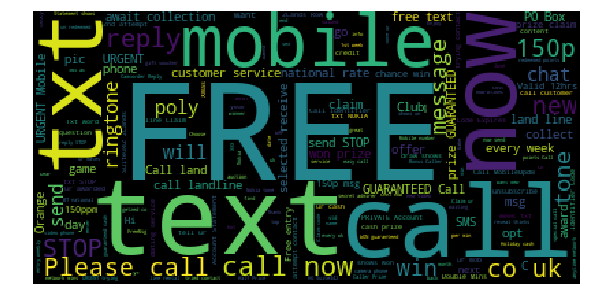

nonspam wordcloud


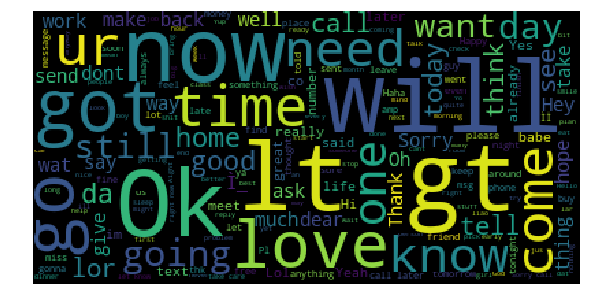

In [143]:
print('spam wordcloud')
spams = df.text[df.labels==1]
show_wordcloud(spams)

print('nonspam wordcloud')
nonspams = df.text[df.labels==0]
show_wordcloud(nonspams)

We now get to the nitty gritty part of NLP, taking raw text, processing it, and turning into vectors of numbers to do ML with. Classical NLP tends to follow the [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model) model. Bag of words basically means that we only care which words appear in the text and how often they appear, not the order in which they appear. This means the order of text in a document won't matter, only the frequency of words that appear.

When doing bag of words, the most common processing steps often done on the text are the following: 

- All text is converted to lower case, that way strings like "love" and "Love" and "LOVE" are treated as one word "love". 
- Punctuation and unusual characters (often non-ascii characters) are removed.
- Stop words, i.e. common English words that occur frequently in text, are removed. These include words like I, we, you, your, to, and, but, etc. The idea is that these words capture very little of the meaning of a sentence, and since they occur so frequently it's often better to remove them so they don't overly skew the results of the model.
- Text is lemmatized or stemmed, which means that words occurring in different inflections are changed to their root word. For example, words like "walk", "walking", and "walked" are changed to the root word "walk". And words like "cat", "catty", and "catlike" are changed to their root word "cat". The idea here is that the root word itself carries more meaning than whatever inflection it happens to appear in in a sentence.

We use the `process_text` function defined above to perform these steps on our raw text, and store this processed text in a new `text_processed` in the dataframe. Observe that words like `Funny` get turned into stuff like `funni`. This is done in purpose by many stemmers, even if it looks weird, and it's not something to worry about.

Note: when preprocessing text, having a good knowledge of regular expressions is essential since you'll use them like crazy to clean up text.

In [144]:
df['text_processed'] = df.text.apply(process_text)
df.head(10)

,labels,text,text_processed
0,0,"Funny fact Nobody teaches volcanoes 2 erupt, t...",funni fact nobodi teach volcano 2 erupt tsunam...
1,0,I sent my scores to sophas and i had to do sec...,sent score sopha secondari applic school think...
2,1,We know someone who you know that fancies you....,know someon know fanci call 09058097218 find p...
3,0,Only if you promise your getting out as SOON a...,promis get soon text morn let know made ok
4,1,Congratulations ur awarded either å£500 of CD ...,congratul ur award either $ 500 cd gift vouche...
5,0,"I'll text carlos and let you know, hang on",i'll text carlo let know hang
6,0,K.i did't see you.:)k:)where are you now?,ki did't see youkwher
7,0,No message..no responce..what happend?,messag responc happend
8,0,Get down in gandhipuram and walk to cross cut ...,get gandhipuram walk cross cut road right side...
9,0,You flippin your shit yet?,flippin shit yet


The next essential step before doing ML is tokenization, which involves converting strings into a list of tokens that will later be converted into numbers for the ML model. There are many different tokenizers out there. NLTK has one of its own. We use the Spacy tokenizer here since it often seems to do a better job (it's newer than NLTK's tokenizer).

Naively speaking, tokenizing a sentence means splitting it into whatever base unit you want to encode. Most of the time it's usually words (called unigrams) or pairs of words (called bigrams). An example of naive unigram tokenization is shown directly below. You're basically just splitting a string on spaces. 

As you can see from the example this doesn't do a terribly good job. For one thing there's a trailing empty string at the end. For another the contraction "I'll", short for "I will", is treated as a single word. Good tokenizers will recognize situations like this and split them accordingly. For example, Spacy converts `i'll` into the two tokens `i` and `'ll`. Similarly, stuff like `can't` become `can` and `'t`. Any empty strings and extra whitespace are also removed. We can see how this works in the second cell below.

In [183]:
sms = df.iloc[5]
doc = sms.text_processed.split(' ')
[token for token in doc]

["i'll", 'text', 'carlo', 'let', 'know', 'hang', '']

In [190]:
nlp = spacy.load('en_core_web_sm')
sms = df.iloc[5]
doc = nlp(sms.text_processed)
[token.text for token in doc]
#grams = [sentence[i:i+N] for i in xrange(len(sentence)-N+1)]

['i', "'ll", 'text', 'carlo', 'let', 'know', 'hang']

We now tokenize the whole corpus of processed text, and store these tokens as strings in the `tokens` column of the dataframe. Notice that even after tokenization there are weird things showing up in the data due to misspellings, e.g. `ki` and `did't`. Trying to correct all of these is an often impossible task. If the same misspelling patterns don't occur too often, it's often easier just to cut them out by keeping only the most frequently occurring tokens, which are hopefully spelled correctly.

In [198]:
nlp = spacy.load('en_core_web_sm')
df['tokens'] = df.text_processed.apply(lambda x:' '.join(t.text for t in nlp.tokenizer(x)))
df.head(10)

,labels,text,text_processed,tokens
0,0,"Funny fact Nobody teaches volcanoes 2 erupt, t...",funni fact nobodi teach volcano 2 erupt tsunam...,funni fact nobodi teach volcano 2 erupt tsunam...
1,0,I sent my scores to sophas and i had to do sec...,sent score sopha secondari applic school think...,sent score sopha secondari applic school think...
2,1,We know someone who you know that fancies you....,know someon know fanci call 09058097218 find p...,know someon know fanci call 09058097218 find p...
3,0,Only if you promise your getting out as SOON a...,promis get soon text morn let know made ok,promis get soon text morn let know made ok
4,1,Congratulations ur awarded either å£500 of CD ...,congratul ur award either $ 500 cd gift vouche...,congratul ur award either $ 500 cd gift vouche...
5,0,"I'll text carlos and let you know, hang on",i'll text carlo let know hang,i 'll text carlo let know hang
6,0,K.i did't see you.:)k:)where are you now?,ki did't see youkwher,ki did't see youkwher
7,0,No message..no responce..what happend?,messag responc happend,messag responc happend
8,0,Get down in gandhipuram and walk to cross cut ...,get gandhipuram walk cross cut road right side...,get gandhipuram walk cross cut road right side...
9,0,You flippin your shit yet?,flippin shit yet,flippin shit yet


Now that we have a list of tokens we can convert them into numbers and do some ML. In the bag of words approach, the simplest thing to do is to convert the tokenized documents into frequency vectors. To do this, you first count how many unique tokens occur in the corpus. This is the vocabulary size $V$. Each unique token is then indexed with a unique number from $0$ to $V-1$. 

Then, each document is converted to a vector as follows: The document is converted to a size $V$ vector of counts. Each value of the vector is a count of the number of times that token occurs in the document. For example, if the token "school" occurs 5 times in a document, and "school" is indexed by 42 in the vocabulary dictionary, then the 42nd position of the vector gets the value 5. Tokens that don't occur at all in a document get the value 0. Since the vocabulary represents the whole corpus, this means that most tokens won't occur in a single given document, which means most of its vector values will be 0. That is, the text frequency vector is sparse. In ML speak, each token in the vocabulary becomes its own feature.

We can get text frequencies from a string by using sklearn's `CountVectorizer`. This can automatically remove stop words, how many n-grams you want to use, how many tokens to keep, and even which tokenizer to use. This means if you're in a hurry you can skip a lot of the preprocessing we just did and feed your text right into the count vectorizer (I wouldn't recommend you always skip this preprocessing, but it often won't hurt performance too much if you're a little lazy here).

Below we use count vectorize using the tokens created above. We keep both unigrams (single words) and bigrams (pairs of words), and truncate to only keep the top 2000 most frequently occuring unigrams and bigrams. The setup is the usual for ML, with `X_counts` being the input data and `y` the corresponding labels.

In [211]:
cv = CountVectorizer(analyzer=str.split,ngram_range=(1,2),stop_words='english',max_features=2000)
X_counts = cv.fit_transform(df.tokens)
y = df.labels
print(X_counts.shape,y.shape)

(5572, 2000) (5572,)


Next we do the ML with the `X_count`,`y` pair. Since we're doing supervised learning we still split the data up into a training and test set. Since the dataset is unbalanced we then use upsampling, particularly SMOTE here, to balance the training set. We then use a simple (non-tuned) random forest to do the classification and print the relevant metrics. You can see that we're already up to about 89.4% in F1 score. The main thing dragging it down appears to be the false negatives, i.e. more spam is being classified as non-spam.

In [212]:
X_train,X_test,y_train,y_test = train_test_split(X_counts, y, test_size=0.2)
X_train_bal,y_train_bal = SMOTE().fit_sample(X_train,y_train)

In [213]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train_bal,y_train_bal)

yhat = model.predict(X_test)
get_scores(y_test,yhat)

accuracy:  0.9704
precision:  0.9859
recall:  0.8187
f1:  0.8946
auc:  0.9083
confusion matrix:
 [[942   2]
 [ 31 140]]


Count vectorizing isn't the only way to convert a set of tokens into an input matrix of numbers. Another common vectorizer is [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), which stands for text frequency - inverse document frequency. This is a somewhat smarter way to keep track of how important words are in a document. Words that occur a lot in a document but don't occur in very many documents receive high scores. This helps mitigate the effect of stop words since they generally occur a lot in a document, but also occur in many documents.

In math terms, tf-idf is calculated as follows. Let $n_{i}^{(d)}$ be the number of times a word $w_i$ occurs in a document $d$, $n^{(d)}$ the number of total words in the document $d$, $N$ the total number of documents (i.e. the corpus size), and $n_i$ the number of documents in the corpus that contain the word $w_i$. Then the tf-idf value for the word $w_i$ in document $d$ is given by
$$t_i^{(d)} = \frac{n_{i}^{(d)}}{n^{(d)}}\log\frac{N}{n_i}.$$

The process is the same as above except we use `TfidfVectorizer` instead. We can see that in this case our F1 score is up to about 90.2%, which is a slight improvement.

In [214]:
tfidf = TfidfVectorizer(analyzer=str.split,ngram_range=(1,2),stop_words='english',max_features=2000)
X_tfidf = tfidf.fit_transform(df.text_processed)
y = df.labels
print(X_tfidf.shape,y.shape)

(5572, 2000) (5572,)


In [215]:
X_train,X_test,y_train,y_test = train_test_split(X_tfidf, y, test_size=0.2)
X_train_bal,y_train_bal = SMOTE().fit_sample(X_train,y_train)

In [216]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train_bal,y_train_bal)

yhat = model.predict(X_test)
get_scores(y_test,yhat)

accuracy:  0.9749
precision:  0.9559
recall:  0.8553
f1:  0.9028
auc:  0.9245
confusion matrix:
 [[957   6]
 [ 22 130]]


We'll close quickly by showing something useful, namely how to interpret a random forest model. Sklearn's random forest class comes with a `feature_importances_` attribute that can be used to show what the top features are that the model uses (on average) to decide how to classify something. In the case of words, we can look at what the most important trigger words the model is using to decide whether something is spam or not. A plot of the top 20 trigger words is shown below. We can see many words showing up that look sensible in determining whether or not a piece of text is spam, e.g. win, free, claim, and urgent. Feature importance plots are often useful for debugging models to make sure that they're making sensible decisions. In our case it looks like the model is behaving smartly, though there is some noise creeping in, e.g. the token 2.

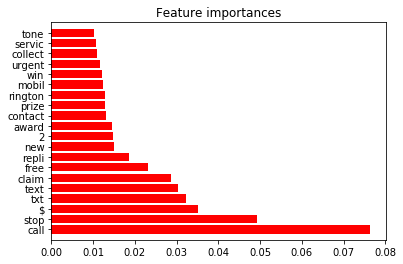

In [220]:
plot_feature_importances(model,tfidf, 20)